## Connected to the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [ ]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Flatten, Dense, Dropout, Reshape
from sklearn.model_selection import train_test_split
import keras


## Dataset Preparation

In [ ]:
import os
import numpy as np
import librosa
import glob

# Path to the dataset folders
yes_drone_path = '/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/yes_drone'
no_drone_path = '/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/unknown'

def load_audio_files_from_directory(directory_path, label, target_length=16000):
    """
    Loads all .wav files in a directory, preprocesses them, and assigns a label.
    """
    data = []
    labels = []

    # Find all .wav files in the directory
    for file_path in glob.glob(os.path.join(directory_path, '*.wav')):
        # Load audio file with librosa
        audio, sr = librosa.load(file_path, sr=16000)  # Resample to 16 kHz

        # Pad or truncate audio to match the target length
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), "constant")
        else:
            audio = audio[:target_length]

        # Append to data list
        data.append(audio)
        labels.append(label)  # Assign the given label (1 for "yes_drone", 0 for "no_drone")

    # Convert lists to numpy arrays
    data = np.array(data).reshape(-1, target_length, 1)  # Shape: (num_samples, 2047, 1)
    labels = np.array(labels)  # Shape: (num_samples,)
    return data, labels

# Load data from each class
X_yes_drone, y_yes_drone = load_audio_files_from_directory(yes_drone_path, label=1)
X_no_drone, y_no_drone = load_audio_files_from_directory(no_drone_path, label=0)

# Combine "yes_drone" and "no_drone" datasets
X_data = np.concatenate([X_yes_drone, X_no_drone], axis=0)
y_data = np.concatenate([y_yes_drone, y_no_drone], axis=0)

# Shuffle the data
indices = np.arange(X_data.shape[0])
np.random.shuffle(indices)
X_data = X_data[indices]
y_data = y_data[indices]

# Print the shape of the dataset
print("Shape of X_data:", X_data.shape)  # Should be (total_samples, 16000, 1)
print("Shape of y_data:", y_data.shape)  # Should be (total_samples,)


Shape of X_data: (11704, 16000, 1)
Shape of y_data: (11704,)


## Save the prepared Dataset

In [ ]:
# Define paths for saving the data
X_data_path = '/content/drive/MyDrive/TinyML_Dataset/X_data.npy'
y_data_path = '/content/drive/MyDrive/TinyML_Dataset/y_data.npy'

# Save X_data and y_data to Google Drive
np.save(X_data_path, X_data)
np.save(y_data_path, y_data)

print("Data saved to Google Drive successfully.")


Data saved to Google Drive successfully.


## Load the Dataset

In [ ]:
# Define paths for saving the data
X_data_path = '/content/drive/MyDrive/TinyML_Dataset/X_data.npy'
y_data_path = '/content/drive/MyDrive/TinyML_Dataset/y_data.npy'

# Load X_data and y_data from Google Drive
X_data = np.load(X_data_path)
y_data = np.load(y_data_path)

print("Data loaded from Google Drive successfully.")
print("Shape of X_data:", X_data.shape)
print("Shape of y_data:", y_data.shape)


Data loaded from Google Drive successfully.
Shape of X_data: (11704, 2047, 1)
Shape of y_data: (11704,)


## Model Configuration

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam

# Model configuration
input_shape = (2047, 1)
num_classes = 2  # Set to 2 for binary classification ("yes_drone" and "no_drone")

# Build the model
model = Sequential()

# Reshape layer (optional here since input is already (2047, 1), but keeping it as a placeholder)
model.add(Reshape((2047, 1), input_shape=input_shape))

# Convolutional Layers with Pooling
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(AveragePooling1D(pool_size=2))  # Specify pool_size
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(AveragePooling1D(pool_size=2))  # Specify pool_size
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(AveragePooling1D(pool_size=2))  # Specify pool_size
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(AveragePooling1D(pool_size=2))  # Specify pool_size

# Dropout for regularization
model.add(Dropout(0.25))

# Flattening and Dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Single neuron with sigmoid for binary classification

# Compile the model with binary crossentropy for binary classification
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)                  │ (None, 2047, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 2045, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_12                 │ (None, 1022, 32)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 1020, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_13                 │ (None, 510, 64)             │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 508, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_14                 │ (None, 254, 128)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 252, 128)            │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_15                 │ (None, 126, 128)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 126, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16128)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       4,129,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,209,601 (16.06 MB)

 Trainable params: 4,209,601 (16.06 MB)

 Non-trainable params: 0 (0.00 B)

## Split the Dataset

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)


Training data shape: (9363, 2047, 1)
Validation data shape: (2341, 2047, 1)


## Train the Model

In [ ]:
# Train the model
batch_size = 50  # You can adjust this based on your memory availability
epochs = 100      # Set the number of epochs as required

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8741 - loss: 0.3608 - val_accuracy: 0.8898 - val_loss: 0.2436
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9000 - loss: 0.2342 - val_accuracy: 0.8962 - val_loss: 0.2733
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9238 - loss: 0.2130 - val_accuracy: 0.9291 - val_loss: 0.1959
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9320 - loss: 0.1902 - val_accuracy: 0.9205 - val_loss: 0.2042
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9422 - loss: 0.1671 - val_accuracy: 0.9291 - val_loss: 0.1897
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9390 - loss: 0.1641 - val_accuracy: 0.9329 - val_loss: 0.1845
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9454 - loss: 0.1466 - val_accuracy: 0.9351 - val_loss: 0.1759
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9511 - loss: 0.1344 -

## Monitor Training

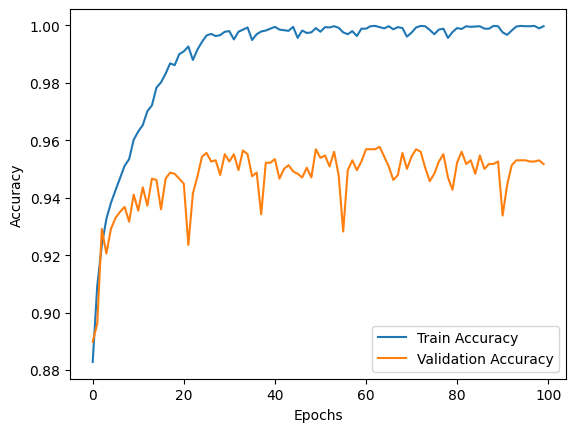

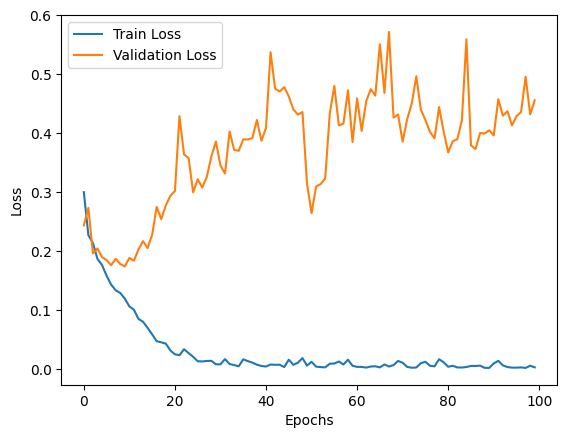

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/Trained_Models/trained_model_0.keras")


Shape of X_data: (11704, 2047, 1)
Shape of y_data: (11704,)
Training Data Shape: (9948, 2047, 1)
Test Data Shape: (1756, 2047, 1)
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test Accuracy: 0.9556
Confusion Matrix:
[[1542   23]
 [  55  136]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1565
           1       0.86      0.71      0.78       191

    accuracy                           0.96      1756
   macro avg       0.91      0.85      0.88      1756
weighted avg       0.95      0.96      0.95      1756



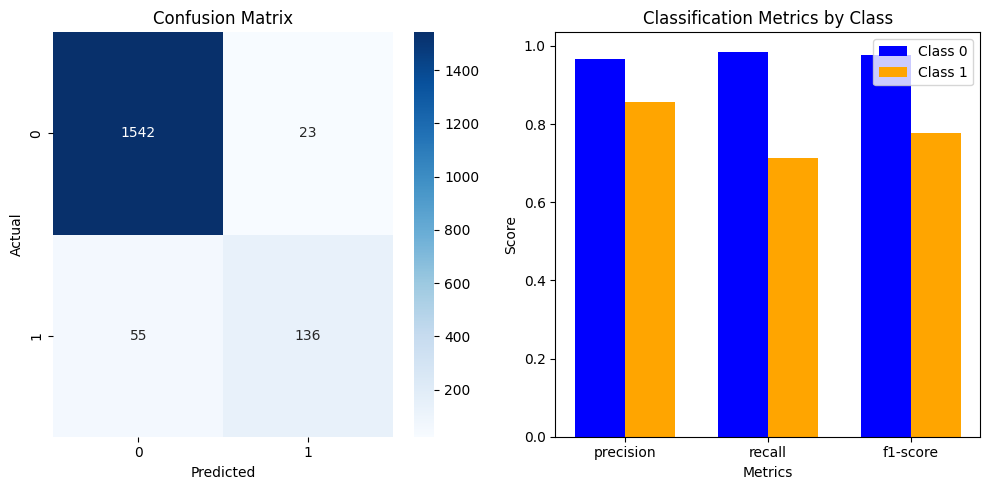

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the preprocessed data
X_data = np.load('/content/drive/MyDrive/TinyML_Dataset/X_data.npy')
y_data = np.load('/content/drive/MyDrive/TinyML_Dataset/y_data.npy')

# Print the shape of the loaded data
print("Shape of X_data:", X_data.shape)  # Should be (num_samples, 2047, 1)
print("Shape of y_data:", y_data.shape)  # Should be (num_samples,)

# Load the trained model (assumes the model is saved in .keras format)
model = tf.keras.models.load_model('/content/drive/MyDrive/Trained_Models/trained_model_0.keras')  # Change path if needed

# Split the data into training and test sets (70% train, 15% validation, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.15, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

# Predict on the test data
predictions = model.predict(X_test)

# Convert probabilities to class labels (1 if probability > 0.5, else 0)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Classification Report (precision, recall, f1-score)
report = classification_report(y_test, predicted_labels, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

# Plotting the confusion matrix
plt.figure(figsize=(10, 5))

# Confusion Matrix Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Bar Plot for Metrics
plt.subplot(1, 2, 2)
metrics = ['precision', 'recall', 'f1-score']
classes = ['Class 0', 'Class 1']
class_0_metrics = [report['0'][metric] for metric in metrics]
class_1_metrics = [report['1'][metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, class_0_metrics, width, label='Class 0', color='blue')
plt.bar(x + width/2, class_1_metrics, width, label='Class 1', color='orange')

plt.title("Classification Metrics by Class")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.show()


## Upgraded version of the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Model configuration
input_shape = (16000, 1)
num_classes = 2  # Binary classification ("yes_drone" and "no_drone")

# Build the model
model1 = Sequential()

# Reshape layer
model1.add(Reshape((16000, 1), input_shape=input_shape))

# Convolutional Layers with Pooling
model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model1.add(AveragePooling1D(pool_size=2))
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model1.add(AveragePooling1D(pool_size=2))
model1.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model1.add(AveragePooling1D(pool_size=2))
model1.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model1.add(AveragePooling1D(pool_size=2))

# Dropout for regularization
model1.add(Dropout(0.2))  # Increased dropout rate

# Flattening and Dense layers
model1.add(Flatten())
model1.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Reduced size, added L2 regularization
model1.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # L2 regularization added

# Compile the model with binary crossentropy for binary classification
model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 16000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 15998, 32)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_4                  │ (None, 7999, 32)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 7997, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_5                  │ (None, 3998, 64)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 3996, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_6                  │ (None, 1998, 128)           │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 1996, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_7                  │ (None, 998, 128)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 998, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 127744)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,351,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,431,809 (62.68 MB)

 Trainable params: 16,431,809 (62.68 MB)

 Non-trainable params: 0 (0.00 B)

## Spliting Dataset into: Training, Validation and Test

In [ ]:
from sklearn.model_selection import train_test_split

# Define paths for saving the data
X_data_path = '/content/drive/MyDrive/TinyML_Dataset/X_data.npy'
y_data_path = '/content/drive/MyDrive/TinyML_Dataset/y_data.npy'

# Load X_data and y_data from Google Drive
X_data = np.load(X_data_path)
y_data = np.load(y_data_path)

print("Data loaded from Google Drive successfully.")
print("Shape of X_data:", X_data.shape)
print("Shape of y_data:", y_data.shape)

# Step 1: Split into 85% train+validation and 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.15, random_state=42)

# Step 2: Split train+validation (85%) into 70% training and 15% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)
# 0.1765 because 15% / 85% ≈ 0.1765

# Print shapes of the splits
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)


Data loaded from Google Drive successfully.
Shape of X_data: (11704, 16000, 1)
Shape of y_data: (11704,)
Training data shape: (8192, 16000, 1)
Validation data shape: (1756, 16000, 1)
Test data shape: (1756, 16000, 1)


## Training the model

In [ ]:
# Train the model on training and validation data
batch_size = 50  # Adjust based on memory availability
epochs = 20     # Number of epochs for training

history = model1.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),  # Validation data for monitoring
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 165ms/step - accuracy: 0.8717 - loss: 0.6343 - val_accuracy: 0.8924 - val_loss: 0.2708
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.8882 - loss: 0.2679 - val_accuracy: 0.9072 - val_loss: 0.2419
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.9140 - loss: 0.2473 - val_accuracy: 0.9015 - val_loss: 0.2636
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.9189 - loss: 0.2473 - val_accuracy: 0.9237 - val_loss: 0.2444
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.9406 - loss: 0.2139 - val_accuracy: 0.9328 - val_loss: 0.2787
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.9443 - loss: 0.2087 - val_accuracy: 0.9436 - val_loss: 0.2123
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9453 - loss: 0.1995 - val_accuracy: 0.9385 - val_loss: 0.2192
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.9470 - loss: 0

## Monitoring the optimized Model

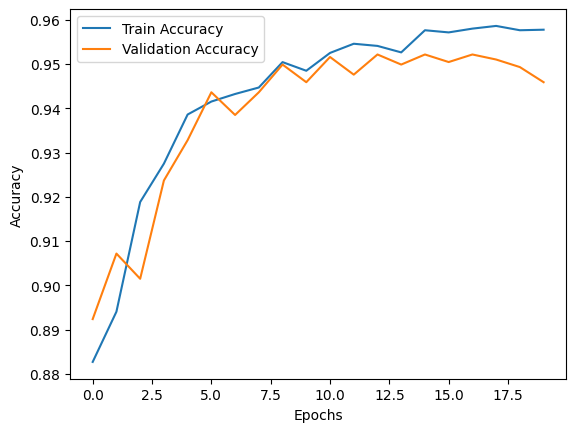

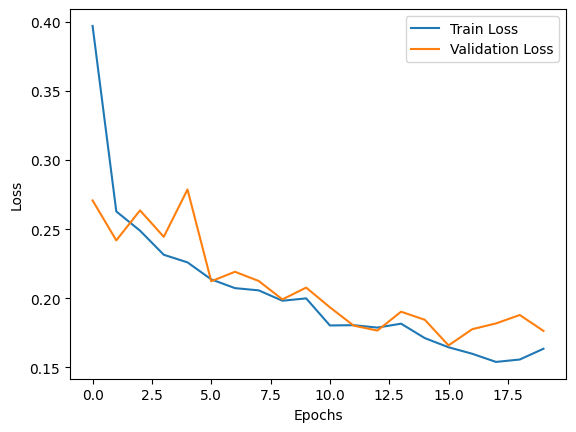

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Save the model

In [ ]:
model1.save("/content/drive/MyDrive/Trained_Models/trained_model_f16.keras")
import tensorflow as tf

# Save the model in a compatible format first
model1.save("/content/drive/MyDrive/Trained_Models/trained_model_f16.keras")  # Or use .h5

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = "/content/drive/MyDrive/Trained_Models/trained_model__f16.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("TFLite model saved successfully!")

Saved artifact at '/tmp/tmpur90xfsj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16000, 1), dtype=tf.float32, name='keras_tensor_92')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136647529880784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136647529877904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136647529880016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136647529884240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136647529877328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136647529882512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136647529883088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136647529888464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136653310547856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136653341245520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13665335670504

## Examples

In [ ]:
import numpy as np
import librosa

model = tf.keras.models.load_model("/content/drive/MyDrive/Trained_Models/trained_model_f.keras")

# Function to load and preprocess audio file
def preprocess_audio(file_path, input_length=2047):
    audio, _ = librosa.load(file_path, sr=16000)  # Resample to 16 kHz
    audio = librosa.util.fix_length(audio, size=input_length)  # Pad or trim to input length
    return np.expand_dims(audio, axis=-1)  # Add channel dimension (shape: (2047, 1))

# Paths to 10 audio files for testing
test_audio_paths = [
    "/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/yes_drone/B_S2_D1_067-bebop_000_.wav",
    "/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/unknown/1-100032-A-02.wav",
    "/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/yes_drone/B_S2_D1_067-bebop_004_.wav",
    "/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/unknown/1-100210-A-363.wav",
    "/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/yes_drone/B_S2_D1_069-bebop_002_.wav",
    "/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/yes_drone/B_S2_D1_070-bebop_003_.wav",
    "/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/unknown/1-101404-A-343.wav",
    "/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/yes_drone/B_S2_D1_073-bebop_001_.wav",
    "/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/unknown/1-103999-A-303.wav",
    "/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/yes_drone/B_S2_D1_075-bebop_001_.wav"
]

# True labels for the audio files (1 = drone, 0 = no drone)
true_labels = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1]

# Preprocess all test audio files
test_audio_data = np.array([preprocess_audio(file_path) for file_path in test_audio_paths])

# Predict using the trained model
predictions = model.predict(test_audio_data)

# Convert probabilities to binary class predictions (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Output the results
for i in range(len(test_audio_paths)):
    print(f"Audio: {test_audio_paths[i]}")
    print(f"True Label: {true_labels[i]} | Predicted Label: {predicted_labels[i][0]} | Probability: {predictions[i][0]:.2f}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
Audio: /content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/yes_drone/B_S2_D1_067-bebop_000_.wav
True Label: 1 | Predicted Label: 1 | Probability: 0.88
--------------------------------------------------
Audio: /content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/unknown/1-100032-A-02.wav
True Label: 0 | Predicted Label: 0 | Probability: 0.00
--------------------------------------------------
Audio: /content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/yes_drone/B_S2_D1_067-bebop_004_.wav
True Label: 1 | Predicted Label: 1 | Probability: 1.00
--------------------------------------------------
Audio: /content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/unknown/1-100210-A-363.wav
True Label: 0 | Predicted Label: 0 | Probability: 0.00
--------------------------------------------------
Audio: /content/drive/MyDrive/TinyML_Dataset/DroneAudi

In [ ]:
import numpy as np

# Check the distribution of the true labels
unique, counts = np.unique(true_labels, return_counts=True)
print("True Labels Distribution:", dict(zip(unique, counts)))


True Labels Distribution: {0: 4, 1: 6}


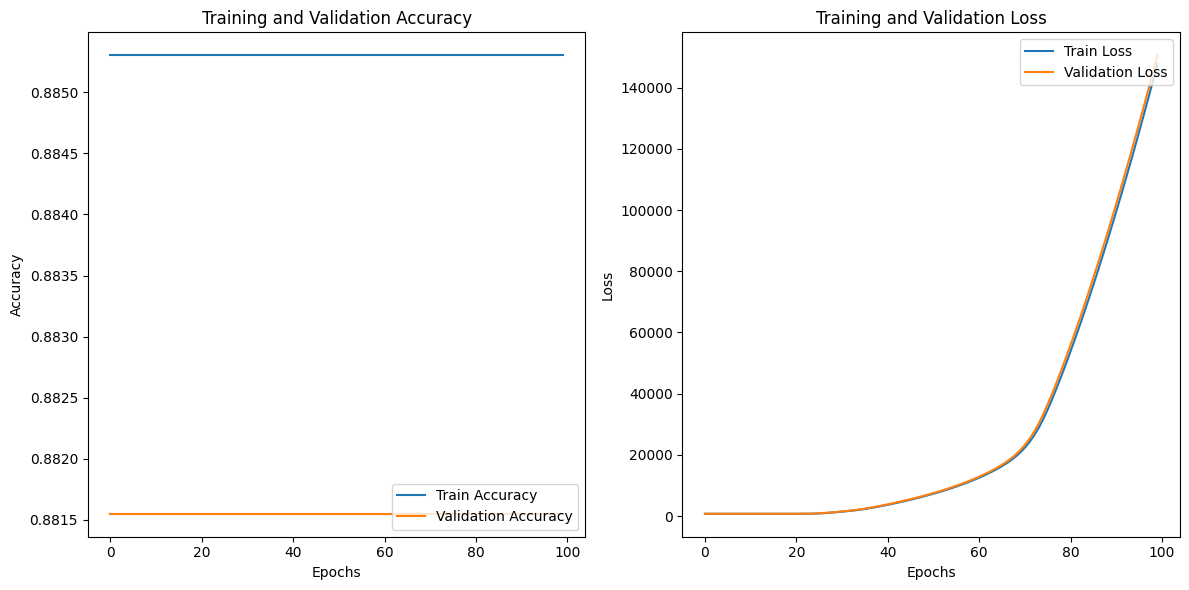

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8860 - loss: 150534.0625
Test Loss: 150534.03125
Test Accuracy: 0.891230046749115


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model1.fit()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Shape of X_data: (11704, 16000, 1)
Shape of y_data: (11704,)
Training Data Shape: (9948, 16000, 1)
Test Data Shape: (1756, 16000, 1)
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Test Accuracy: 0.9550
Confusion Matrix:
[[1526   31]
 [  48  151]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1557
           1       0.83      0.76      0.79       199

    accuracy                           0.96      1756
   macro avg       0.90      0.87      0.88      1756
weighted avg       0.95      0.96      0.95      1756



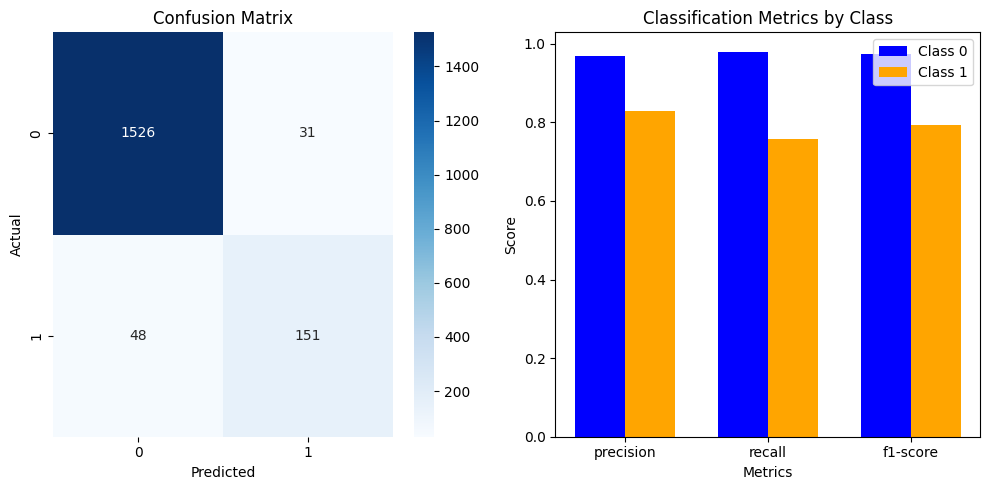

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the preprocessed data
X_data = np.load('/content/drive/MyDrive/TinyML_Dataset/X_data.npy')
y_data = np.load('/content/drive/MyDrive/TinyML_Dataset/y_data.npy')

# Print the shape of the loaded data
print("Shape of X_data:", X_data.shape)  # Should be (num_samples, 2047, 1)
print("Shape of y_data:", y_data.shape)  # Should be (num_samples,)

# Load the trained model (assumes the model is saved in .keras format)
model = tf.keras.models.load_model('/content/drive/MyDrive/Trained_Models/trained_model_f16.keras')  # Change path if needed

# Split the data into training and test sets (70% train, 15% validation, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.15, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

# Predict on the test data
predictions = model.predict(X_test)

# Convert probabilities to class labels (1 if probability > 0.5, else 0)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Classification Report (precision, recall, f1-score)
report = classification_report(y_test, predicted_labels, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

# Plotting the confusion matrix
plt.figure(figsize=(10, 5))

# Confusion Matrix Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Bar Plot for Metrics
plt.subplot(1, 2, 2)
metrics = ['precision', 'recall', 'f1-score']
classes = ['Class 0', 'Class 1']
class_0_metrics = [report['0'][metric] for metric in metrics]
class_1_metrics = [report['1'][metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, class_0_metrics, width, label='Class 0', color='blue')
plt.bar(x + width/2, class_1_metrics, width, label='Class 1', color='orange')

plt.title("Classification Metrics by Class")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.show()


## Audio preprocessing

In [ ]:
import numpy as np
import librosa
import tensorflow as tf

# Constants
SAMPLE_RATE = 16000  # Sampling rate for audio
SEGMENT_DURATION = 1 # Duration of each segment in seconds
TARGET_LENGTH = 2047 # Target length for each segment
MODEL_PATH = '/content/drive/MyDrive/Trained_Models/trained_model_f.keras' # Path to the saved model

# Load the pre-trained model
model = tf.keras.models.load_model(MODEL_PATH)

def preprocess_audio_segment(audio):
    """
    Preprocess a 1-second audio segment: resampling, padding/truncating, and reshaping.
    """
    # Resample audio to the target sample rate
    audio = librosa.resample(audio, orig_sr=SAMPLE_RATE, target_sr=SAMPLE_RATE)
    # Pad or truncate to match the target length
    if len(audio) < TARGET_LENGTH:
        audio = np.pad(audio, (0, TARGET_LENGTH - len(audio)), "constant")
    else:
        audio = audio[:TARGET_LENGTH]
    # Reshape for model input
    return audio.reshape(1, TARGET_LENGTH, 1)

def predict_drone(audio_data):
    """
    Predict whether a drone sound is present in the audio data.
    """
    processed_data = preprocess_audio_segment(audio_data)
    prediction = model.predict(processed_data)
    return 1 if prediction[0] > 0.5 else 0

def process_audio_file(file_path):
    """
    Process a 20-second audio file, split it into 1-second segments, and make predictions.
    """
    print(f"Loading audio file: {file_path}")
    # Load the full audio file
    audio_data, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    print(f"Audio file loaded. Length: {len(audio_data) / sr:.2f} seconds")

    print("Processing and predicting...")
    for i in range(0, len(audio_data), SAMPLE_RATE * SEGMENT_DURATION):
        # Extract 1-second segment
        segment = audio_data[i:i + SAMPLE_RATE * SEGMENT_DURATION]
        if len(segment) < SAMPLE_RATE * SEGMENT_DURATION:
            break  # Ignore incomplete segments
        # Predict and print the result
        result = predict_drone(segment)
        print(result)

# Example usage
file_path = '/content/drive/MyDrive/TinyML_Dataset/audio_drone_test.wav'  # Replace with the path to your audio file
process_audio_file(file_path)


Loading audio file: /content/drive/MyDrive/TinyML_Dataset/audio_drone_test.wav
Audio file loaded. Length: 19.62 seconds
Processing and predicting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0


 ## Audio preprocessing without librosa

In [ ]:
## No working solution yet

In [ ]:
import numpy as np
import tensorflow as tf
from scipy.io import wavfile
from scipy.signal import resample

# Constants
SAMPLE_RATE = 16000  # Sampling rate for audio
SEGMENT_DURATION = 1 # Duration of each segment in seconds
TARGET_LENGTH = 2047 # Target length for each segment
MODEL_PATH = '/content/drive/MyDrive/Trained_Models/trained_model_f.keras' # Path to the saved model

# Load the pre-trained model
model = tf.keras.models.load_model(MODEL_PATH)

def preprocess_audio_segment(audio):
    """
    Preprocess a 1-second audio segment: resampling, padding/truncating, and reshaping.
    """
    # Resample audio to the target sample rate
    if len(audio) != SAMPLE_RATE:
        audio = resample(audio, SAMPLE_RATE)
    # Pad or truncate to match the target length
    if len(audio) < TARGET_LENGTH:
        audio = np.pad(audio, (0, TARGET_LENGTH - len(audio)), "constant")
    else:
        audio = audio[:TARGET_LENGTH]
    # Reshape for model input
    return audio.reshape(1, TARGET_LENGTH, 1)

def predict_drone(audio_data):
    """
    Predict whether a drone sound is present in the audio data.
    """
    processed_data = preprocess_audio_segment(audio_data)
    prediction = model.predict(processed_data)
    return 1 if prediction[0] > 0.5 else 0

def process_audio_file(file_path):
    """
    Process a 20-second audio file, split it into 1-second segments, and make predictions.
    """
    print(f"Loading audio file: {file_path}")
    # Read the full audio file
    sr, audio_data = wavfile.read(file_path)
    if audio_data.ndim > 1:  # If stereo, use one channel
        audio_data = audio_data[:, 0]
    # Resample if needed
    if sr != SAMPLE_RATE:
        audio_data = resample(audio_data, int(len(audio_data) * SAMPLE_RATE / sr))
    print(f"Audio file loaded. Length: {len(audio_data) / SAMPLE_RATE:.2f} seconds")

    print("Processing and predicting...")
    for i in range(0, len(audio_data), SAMPLE_RATE * SEGMENT_DURATION):
        # Extract 1-second segment
        segment = audio_data[i:i + SAMPLE_RATE * SEGMENT_DURATION]
        if len(segment) < SAMPLE_RATE * SEGMENT_DURATION:
            break  # Ignore incomplete segments
        # Predict and print the result
        result = predict_drone(segment)
        print(result)

# Example usage
file_path = '/content/drive/MyDrive/TinyML_Dataset/audio_drone_test.wav'  # Replace with the path to your audio file
process_audio_file(file_path)


Loading audio file: /content/drive/MyDrive/TinyML_Dataset/audio_drone_test.wav
Audio file loaded. Length: 19.62 seconds
Processing and predicting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
